The training dataset comprises five columns: 'Id', 'keyword', 'location', 'text', and 'target'. However, for our natural language processing (NLP) task aimed at predicting natural disasters from tweet content, we'll primarily utilize the 'text' and 'target' columns. These columns contain the tweet text and the corresponding target label, indicating whether the tweet is related to a natural disaster or not.

Our preprocessing pipeline will focus on cleaning and tokenizing the tweet text. This involves removing any irrelevant characters, such as special symbols and punctuation marks, and breaking down the text into individual words or tokens. This process is essential for transforming the raw text data into a format that can be effectively processed by the neural network.

By cleaning and tokenizing the tweet text, we aim to create structured input data that captures the semantic meaning of the tweets. This structured representation will serve as the basis for training our neural network model to accurately classify tweets based on their relevance to natural disasters.

In [335]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Input
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



In [336]:
data = pd.read_csv('train.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [337]:
data=data.drop(["keyword","location"],axis=1)
data.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [338]:
#The punctuation marks are substracted in order to optimize the size of information that we are going to use
def cleantext(text):
    cleantext = re.sub(r'[^\w\s]', '', text)
    text_array = cleantext.split(" ")
    return text_array

data['text'] = data['text'].apply(cleantext)
data.head()

,id,text,target
0,1,"[Our, Deeds, are, the, Reason, of, this, earth...",1
1,4,"[Forest, fire, near, La, Ronge, Sask, Canada]",1
2,5,"[All, residents, asked, to, shelter, in, place...",1
3,6,"[13000, people, receive, wildfires, evacuation...",1
4,7,"[Just, got, sent, this, photo, from, Ruby, Ala...",1


In [339]:
#we substract the words with a size smaller than 3
data['text'] = data['text'].apply(lambda x: [word for word in x if len(word) > 3])
data.head()

,id,text,target
0,1,"[Deeds, Reason, this, earthquake, ALLAH, Forgive]",1
1,4,"[Forest, fire, near, Ronge, Sask, Canada]",1
2,5,"[residents, asked, shelter, place, being, noti...",1
3,6,"[13000, people, receive, wildfires, evacuation...",1
4,7,"[Just, sent, this, photo, from, Ruby, Alaska, ...",1


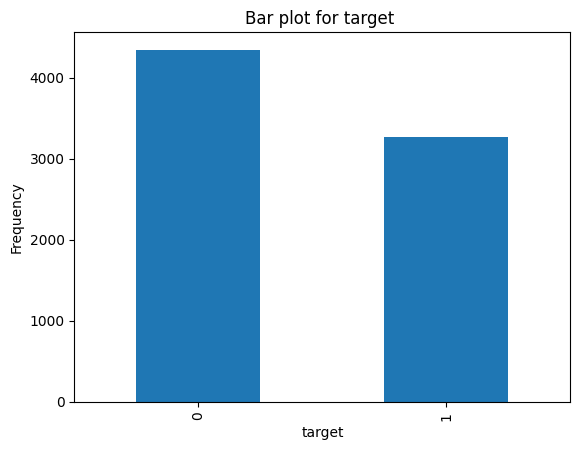

In [340]:
counts = data['target'].value_counts()
counts.plot(kind='bar')
plt.title('Bar plot for target ')
plt.xlabel('target')
plt.ylabel('Frequency')
plt.show()


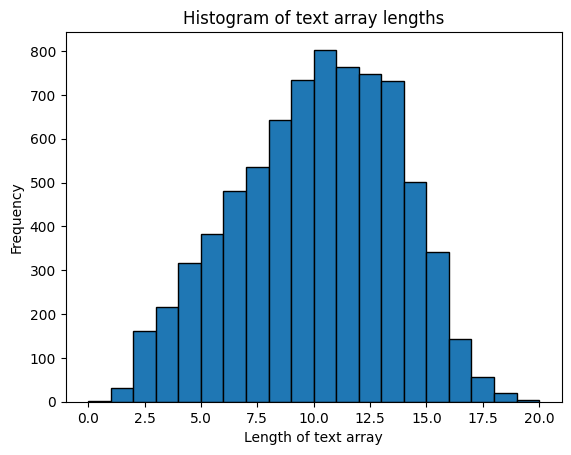

In [341]:
#Plot the number of words in the tweets
lengths = data['text'].apply(len)
# Crear el histograma
plt.hist(lengths, bins=range(min(lengths), max(lengths) + 1), edgecolor='black')
plt.xlabel('Length of text array')
plt.ylabel('Frequency')
plt.title('Histogram of text array lengths')
plt.show()

In [342]:
#the text is tokenizing 
data_train = data.sample(frac=1, random_state=42).reset_index(drop=True)
tokenizer = Tokenizer(num_words=4000)
tokenizer.fit_on_texts(data_train["text"])
sequences = tokenizer.texts_to_sequences(data_train["text"])
max_length = 20 
text = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
targets=data_train["target"]
text_train, text_test, targets_train, targets_test = train_test_split(text, targets, test_size=0.2, random_state=42)

In [343]:
config_layers = [
    Input((20,)),
    Embedding(4000, 200),
    SpatialDropout1D(0.2),
    LSTM(150, dropout=0.7, recurrent_dropout=0.7),
    Dense(1, activation='sigmoid', kernel_regularizer=l1(0.01))]
model=Sequential(config_layers)
model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_24 (Embedding)             │ (None, 20, 200)             │         800,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_24                 │ (None, 20, 200)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_24 (LSTM)                       │ (None, 150)                 │         210,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,010,751 (3.86 MB)

 Trainable params: 1,010,751 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

This neural network architecture comprises an input layer specifying the shape of the input data, followed by an embedding layer that learns dense word representations in a low-dimensional vector space. A SpatialDropout1D layer is then applied to the input to prevent overfitting during training. Subsequently, an LSTM layer with 150 units and a dropout rate of 50% is employed for sequence processing. The network concludes with a dense output layer containing a single neuron with a sigmoid activation function, which outputs the probability of an instance belonging to the positive class. Additionally, L1 regularization with a penalty parameter of 0.002 is applied to the weights of the output layer. Finally, the model is compiled with binary cross-entropy loss, Adam optimizer, and accuracy metric for evaluation during training.

In [344]:
history=model.fit(text_train, targets_train, epochs=100, batch_size=50, validation_split=0.3)

Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5707 - loss: 0.8127 - val_accuracy: 0.5884 - val_loss: 0.7396
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5902 - loss: 0.7147 - val_accuracy: 0.7739 - val_loss: 0.5514
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7844 - loss: 0.5479 - val_accuracy: 0.7739 - val_loss: 0.5539
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8126 - loss: 0.5055 - val_accuracy: 0.7756 - val_loss: 0.5475
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8170 - loss: 0.4996 - val_accuracy: 0.7668 - val_loss: 0.5568
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8268 - loss: 0.4854 - val_accuracy: 0.7696 - val_loss: 0.5718
Epoch 7/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8386 - loss: 0.4653 - val_accuracy: 0.7761 - val_loss: 0.5832
Epoch 8/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8433 - loss: 0.4498 - val_accuracy: 0.

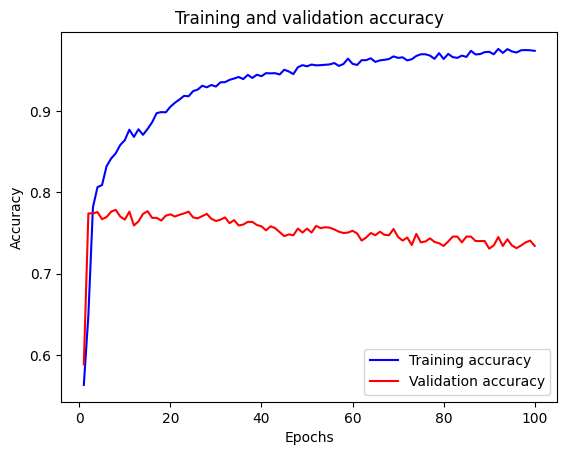

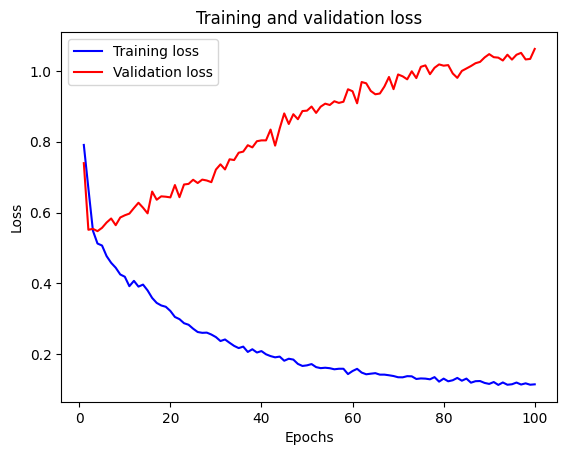

In [345]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy') 
plt.legend()
plt.show()
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [346]:
test_loss, test_acc = model.evaluate(text_test, targets_test)
print(f'Test accuracy: {test_acc}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7180 - loss: 1.1289
Test accuracy: 0.7288246750831604


In [347]:
config_layers = [
    Input((20,)),
    Embedding(4000, 200),
    SpatialDropout1D(0.2),
    LSTM(150, dropout=0.7, recurrent_dropout=0.7),
    Dense(1, activation='sigmoid', kernel_regularizer=l1(0.01))]
model=Sequential(config_layers)
model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(text_train, targets_train, epochs=4, batch_size=50, validation_split=0.3)

Epoch 1/4
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5548 - loss: 0.8033 - val_accuracy: 0.5884 - val_loss: 0.7287
Epoch 2/4
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5899 - loss: 0.7086 - val_accuracy: 0.7783 - val_loss: 0.5426
Epoch 3/4
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7758 - loss: 0.5527 - val_accuracy: 0.7915 - val_loss: 0.5328
Epoch 4/4
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8163 - loss: 0.4983 - val_accuracy: 0.7827 - val_loss: 0.5556


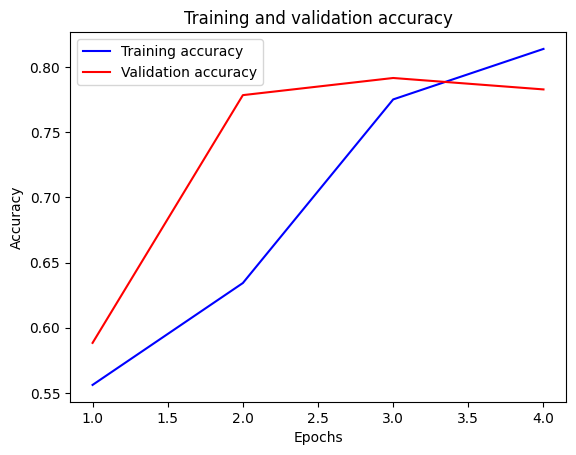

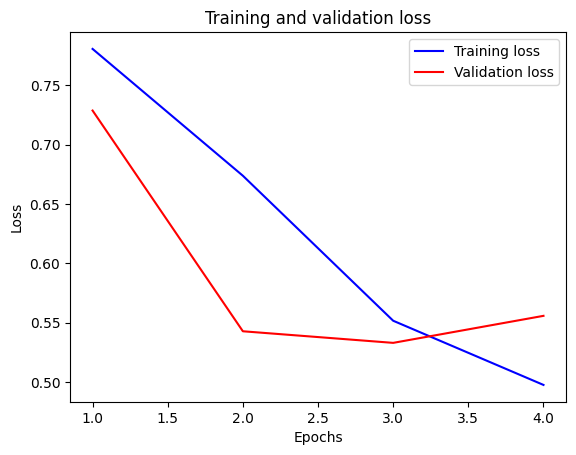

In [348]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [349]:
test_loss, test_acc = model.evaluate(text_test, targets_test)
print(f'Test accuracy: {test_acc}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7540 - loss: 0.5977
Test accuracy: 0.7616546154022217


In [350]:
data_test = pd.read_csv('test.csv')
data_test.head()
data_submission = pd.read_csv('sample_submission.csv')
data_test['text'] = data_test['text'].astype(str)
data_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [351]:
def data_preparation (data):
    data['text'] = data['text'].apply(cleantext)
    data['text'] = data['text'].apply(lambda x: [word for word in x if len(word) > 3])
    tokenizer = Tokenizer(num_words=4000)
    tokenizer.fit_on_texts(data["text"])
    sequences = tokenizer.texts_to_sequences(data["text"])
    max_length = 20 
    text = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
    return text

In [352]:
text=data_preparation(data_test)
id=data_test["id"]

In [366]:
targets = model.predict(text)
targets = (targets >= 0.5).astype(int)
data_submission['target'] = targets
data_submission.to_csv('submission_1.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [367]:
data_submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [368]:
data_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int32
dtypes: int32(1), int64(1)
memory usage: 38.4 KB


Results and Analysis

As observed during training, using a large number of epochs tends to lead to overfitting the model. While the accuracy of the training data increases, the validation accuracy decreases. Therefore, the actual accuracy for predicting new data is lower than what could be achieved with fewer epochs due to overfitting. Hence, it is advisable to train the model with a limited number of epochs, preferably less than 20, to avoid overfitting. Additionally, it's crucial to implement mechanisms to prevent overfitting, such as the SpatialDropout layer, dropout terms in the LSTM layer, and kernel regularization in the final layer. These mechanisms allow for random selection of data or elements to be excluded from training or penalized during training, resulting in better performance despite the loss of validation accuracy due to overfitting.

Conclusion


The competition resulted in an accuracy score that was disappointingly low, hovering around 0.5. This indicates a clear need for improvement in either the NLP model itself or in the data cleaning procedures. It appears that emoticons, URLs, and hashtags were not properly cleaned from the data, which likely affected the model's performance negatively.
Moving forward, we plan to enhance the NLP model by refining its architecture, fine-tuning hyperparameters, and implementing more robust preprocessing steps to ensure that irrelevant text elements like emoticons, URLs, and hashtags are effectively removed. By doing so, we anticipate a significant improvement in the model's performance and its ability to accurately classify text data.
In conclusion, while the initial results may not have met our expectations, we are optimistic about the potential for improvement through iterative refinement and optimization of both the NLP model and the data preprocessing pipeline.